# Unit E
# SQL Over Anything with Drill and Spark

- Examples From Video Lecture 

In [1]:
import pyspark
from pyspark.sql import SparkSession

bucket = "e-drill"

spark = SparkSession.builder \
    .master("local") \
    .appName('jupyter-pyspark') \
        .config("spark.jars.packages","org.apache.hadoop:hadoop-aws:3.3.4,org.apache.spark:spark-avro_2.12:3.1.2")\
        .config("spark.hadoop.fs.s3a.endpoint", "http://minio:9000") \
        .config("spark.hadoop.fs.s3a.access.key", "minio") \
        .config("spark.hadoop.fs.s3a.secret.key", "SU2orange!") \
        .config("spark.hadoop.fs.s3a.fast.upload", True) \
        .config("spark.hadoop.fs.s3a.path.style.access", True) \
        .config("spark.hadoop.fs.s3a.impl", "org.apache.hadoop.fs.s3a.S3AFileSystem") \
        .config('spark.hadoop.fs.s3a.aws.credentials.provider', 'org.apache.hadoop.fs.s3a.SimpleAWSCredentialsProvider') \
    .getOrCreate()
sc = spark.sparkContext
sc.setLogLevel("ERROR") # Keeps the noise down!!!

## Setup

- Put data in the right places!!!
- Run these cells to ensure you have the data for the examples

In [2]:
! pip install -q minio

In [2]:
from minio import Minio

# Make the minio bucket
client = Minio("minio:9000","minio","SU2orange!", secure=False)
not client.bucket_exists(bucket) and client.make_bucket(bucket)

# open the example(s)
gp = spark.read.json("file:///home/jovyan/datasets/json-samples/google-places.json")
c = spark.read.csv("file:///home/jovyan/datasets/customers/customers.csv", inferSchema=True, header=True)
s = spark.read.csv("file:///home/jovyan/datasets/customers/surveys.csv",inferSchema=True, header=True)
g = spark.read.csv("file:///home/jovyan/datasets/grades/*.tsv",inferSchema=False, header=False, sep="\t")

# Put the examples in minio
gp.write.mode("Overwrite").json(f"s3a://{bucket}/google-places.json")
c.write.mode("Overwrite").csv(f"s3a://{bucket}/customers.csv",header=True)
s.write.mode("Overwrite").csv(f"s3a://{bucket}/surveys.csv",header=True)
g.write.mode("Overwrite").csv(f"s3a://{bucket}/grades.csv",header=False, sep=",")
g.write.mode("Overwrite").parquet(f"s3a://{bucket}/grades.parquet")

#put the examples in HDFS
gp.write.mode("Overwrite").json(f"hdfs://namenode/user/root/{bucket}/google-places.json")
c.write.mode("Overwrite").csv(f"hdfs://namenode/user/root/{bucket}/customers.csv",header=True)
s.write.mode("Overwrite").csv(f"hdfs://namenode/user/root/{bucket}/surveys.csv",header=True)
g.write.mode("Overwrite").csv(f"hdfs://namenode/user/root/{bucket}/grades.csv",header=False, sep=",")
g.write.mode("Overwrite").parquet(f"hdfs://namenode/user/root/{bucket}/grades.parquet")

## Apache Drill

These Examples Use Apache Drill. Content is here for reference only.

### Drilling Object Storage / Minio

```
MINIO UI

Make Bucket e-demo
Make folder examscores
Upload file exam-scores.xlsx

Drill Storage Config:

Setup S3 storage plugin, call it s3edemo
Make sure xlsx file extensions point to the correct driver.

DRILL QUERIES:

Select * from ,* from s3edemo.`excel/exam-scores.xlsx`

select ntile(4) over (order by student_score desc) as ranking,* from s3demo.`excel/exam-scores.xlsx`

select avg(Student_Score) over (partition by exam_version ) as avg_by_exam_version,avg(Student_Score) over( partition by class_section) as avg_by_class_section,* from s3demo.`excel/exam-scores.xlsx`
```

### Drilling HDFS

```

Drill Storage Config:

 - use file config
 - set connection to hdfs://namenode:8020
 - set root location to hdfs path /user/root/
 - make sure you have formats correct for your file types
 
 
DRILL QUERIES: 


select * from hdfs.root.`e-drill/customers.csv`;

select * from hdfs.root.`e-drill/grades.parquet`;

```


### Drilling Web Services over HTTP

```
Drill Storage config: Singlefile: STOCKS
-----------------------------

      "stocks": {
        "url": "https://raw.githubusercontent.com/mafudge/datasets/master/stocks/stocks.json",
        "requireTail": false,
}


DRILL QUERIES: 

select * from http.stocks;



Drill Storage Config: a requireTail example
-------------------------------------------

Query all files here: https://github.com/mafudge/advanced-databases/tree/main/datasets/json-samples


 "jsonsamples" : {        "url" : "https://raw.githubusercontent.com/mafudge/advanced-databases/main/datasets/json-samples/",        "requireTail" : true    }


DRILL QUERIES: 

select * from http.jsonsamples.`stocks.json`;

select * from http.jsonsamples.`US-Senators.json`;

select * from http.jsonsamples.`europe.json`;



Drill Storage Config DATAPATH and PARAMETERS 
---------------------------------------------

 "sunrise": {      "url": "https://api.sunrise-sunset.org/json", "params": [        "lat",        "lng",        "date"      ],      "dataPath": "results",      "requireTail": false },
 
 
DRILL QUERIES:

select * from http.sunrise; 


Drill Storage Config: WEATHER API 
----------------------------------


 "weather_daily": {      "url": "https://api.openweathermap.org/data/2.5/onecall",      "method": "GET",      "headers": null,      "authType": "none",      "userName": null,      "password": null,      "postBody": null,      "params": [        "lat",        "lon",        "appid",        "units"      ],      "dataPath": "daily",      "requireTail": false,      "inputType": "json"  }

DRILL QUERIES: 

select * from http.weather_daily`;


```


### Creating Table Schemas

```

SELECT * FROM s3. `grades.csv`

Whoops header is first row!


Configure storage provider to not include header

SELECT * FROM s3. `grades.csv`

Whoops one column names “COLUMNS” with an array of values

-- parse the columns
SELECT COLUMNS[0], COLUMNS[1] FROM s3. `grades/*.tsv`

--with names and types
SELECT cast(COLUMNS[0] as int) as year, COLUMNS[1] FROM s3..`grades/*.tsv`

-- as a CTE
with grades as (
    select cast(COLUMNS[0] as int) as year, 
COLUMNS[1] as semester,
COLUMNS[2] as course,
cast(COLUMNS[3] as int) as credits,
COLUMNS[4] as letter_grade
from s3.`grades/*.tsv`
    )
select * from grades

```

### Creating Tables and Views

```
See what's out there:

SHOW SCHEMA or SHOW DATABASES

Which are writable?

DESCRIBE SCHEMA s3

create view s3.`vgrades` (year, semester,course, credits, gradee)  as  select * from  hdfs.root.`e-drill/grades.parquet`

SHOW TABLES 

Select * from s3.vgrades

drop view  s3.vgrades 

Go check it out on minio... a little file with the query plan!!!

Try to create a table from http.stocks

create table dfs.tmp.stocks asselect symbol, price from http.stocks

Select * from dfs.tmp.stocks
```

### Drilling Nested JSON

```
select g.name,     g.geometry.location.lat as `lat`,     g.geometry.location.lng as `lng`,     FLATTEN(g.types) as `type`,     * from s3.`google-places.json` as g

select s.`congress_numbers`[0], * from http.jsonsamples.`US-Senators.json` s

```

## Spark SQL

- Spark Supports ANSI Standard SQL
- Once you register a DataFrame as a Temp View, you can query it like an SQL table.
- The output is a DataFrame, that you can maniuplate further with spark!

In [3]:
c = spark.read.csv("file:///home/jovyan/datasets/customers/customers.csv", inferSchema=True, header=True)
s = spark.read.csv("file:///home/jovyan/datasets/customers/surveys.csv",inferSchema=True, header=True)


In [4]:
c.createOrReplaceTempView("customers")
s.createOrReplaceTempView("surveys")
c.printSchema()
s.printSchema()

root
 |-- First: string (nullable = true)
 |-- Last: string (nullable = true)
 |-- Email: string (nullable = true)
 |-- Gender: string (nullable = true)
 |-- Last IP Address: string (nullable = true)
 |-- City: string (nullable = true)
 |-- State: string (nullable = true)
 |-- Total Orders: integer (nullable = true)
 |-- Total Purchased: integer (nullable = true)
 |-- Months Customer: integer (nullable = true)

root
 |-- Email: string (nullable = true)
 |-- Twitter Username: string (nullable = true)
 |-- Marital Status: string (nullable = true)
 |-- Household Income: string (nullable = true)
 |-- Own Home: string (nullable = true)
 |-- Education: string (nullable = true)
 |-- Favorite Department: string (nullable = true)



In [5]:
query = '''
select c.Email, c.Gender, c.State, c.`Months Customer`, s.`Own Home`, s.`Household Income`
from customers c left join surveys s on 
        c.Email = s.Email
    where c.State = 'NY'
    and c.`Months Customer` > 5
    and s.`Own Home` is not null
'''
df = spark.sql(query)
df.show()
df.printSchema()

+--------------------+------+-----+---------------+--------+--------------------+
|               Email|Gender|State|Months Customer|Own Home|    Household Income|
+--------------------+------+-----+---------------+--------+--------------------+
|etasomthin@superr...|     M|   NY|             28|      No|               39000|
|   jpoole@dayrep.com|     F|   NY|             12|     Yes|Prefer not to Answer|
| ojouglad@einrot.com|     M|   NY|             36|      No|               65000|
| rovlight@dayrep.com|     M|   NY|             42|      No|               28000|
| sladd@superrito.com|     M|   NY|             10|     Yes|               52000|
+--------------------+------+-----+---------------+--------+--------------------+

root
 |-- Email: string (nullable = true)
 |-- Gender: string (nullable = true)
 |-- State: string (nullable = true)
 |-- Months Customer: integer (nullable = true)
 |-- Own Home: string (nullable = true)
 |-- Household Income: string (nullable = true)



In [6]:
c.createOrReplaceTempView("customers")
s.createOrReplaceTempView("surveys")
c.printSchema()
s.printSchema()

root
 |-- First: string (nullable = true)
 |-- Last: string (nullable = true)
 |-- Email: string (nullable = true)
 |-- Gender: string (nullable = true)
 |-- Last IP Address: string (nullable = true)
 |-- City: string (nullable = true)
 |-- State: string (nullable = true)
 |-- Total Orders: integer (nullable = true)
 |-- Total Purchased: integer (nullable = true)
 |-- Months Customer: integer (nullable = true)

root
 |-- Email: string (nullable = true)
 |-- Twitter Username: string (nullable = true)
 |-- Marital Status: string (nullable = true)
 |-- Household Income: string (nullable = true)
 |-- Own Home: string (nullable = true)
 |-- Education: string (nullable = true)
 |-- Favorite Department: string (nullable = true)



In [8]:
query = '''
select c.Email, c.Gender, c.State, c.`Months Customer`, s.`Own Home`, 
    case s.`Household Income` 
        when 'Prefer not to Answer' then null 
        else cast(s.`Household Income` as DOUBLE) 
    end as Income
from customers c left join surveys s on 
        c.Email = s.Email
    where c.State = 'NY'
    and c.`Months Customer` > 5
    and s.`Own Home` is not null
'''
df = spark.sql(query)
df.show()

+--------------------+------+-----+---------------+--------+-------+
|               Email|Gender|State|Months Customer|Own Home| Income|
+--------------------+------+-----+---------------+--------+-------+
|etasomthin@superr...|     M|   NY|             28|      No|39000.0|
|   jpoole@dayrep.com|     F|   NY|             12|     Yes|   NULL|
| ojouglad@einrot.com|     M|   NY|             36|      No|65000.0|
| rovlight@dayrep.com|     M|   NY|             42|      No|28000.0|
| sladd@superrito.com|     M|   NY|             10|     Yes|52000.0|
+--------------------+------+-----+---------------+--------+-------+



In [9]:
df.printSchema()
df.explain()
df.createOrReplaceTempView("v_ny_customer_analysis")

root
 |-- Email: string (nullable = true)
 |-- Gender: string (nullable = true)
 |-- State: string (nullable = true)
 |-- Months Customer: integer (nullable = true)
 |-- Own Home: string (nullable = true)
 |-- Income: double (nullable = true)

== Physical Plan ==
AdaptiveSparkPlan isFinalPlan=false
+- Project [Email#332, Gender#333, State#336, Months Customer#339, Own Home#371, CASE WHEN (Household Income#370 = Prefer not to Answer) THEN null ELSE cast(Household Income#370 as double) END AS Income#419]
   +- BroadcastHashJoin [Email#332], [Email#367], Inner, BuildRight, false
      :- Filter ((((isnotnull(State#336) AND isnotnull(Months Customer#339)) AND (State#336 = NY)) AND (Months Customer#339 > 5)) AND isnotnull(Email#332))
      :  +- FileScan csv [Email#332,Gender#333,State#336,Months Customer#339] Batched: false, DataFilters: [isnotnull(State#336), isnotnull(Months Customer#339), (State#336 = NY), (Months Customer#339 > 5..., Format: CSV, Location: InMemoryFileIndex(1 paths)[fi

## Spark SQL works with Nested Data

In [10]:
gp.printSchema()

root
 |-- business_status: string (nullable = true)
 |-- geometry: struct (nullable = true)
 |    |-- location: struct (nullable = true)
 |    |    |-- lat: double (nullable = true)
 |    |    |-- lng: double (nullable = true)
 |    |-- viewport: struct (nullable = true)
 |    |    |-- northeast: struct (nullable = true)
 |    |    |    |-- lat: double (nullable = true)
 |    |    |    |-- lng: double (nullable = true)
 |    |    |-- southwest: struct (nullable = true)
 |    |    |    |-- lat: double (nullable = true)
 |    |    |    |-- lng: double (nullable = true)
 |-- icon: string (nullable = true)
 |-- icon_background_color: string (nullable = true)
 |-- icon_mask_base_uri: string (nullable = true)
 |-- name: string (nullable = true)
 |-- opening_hours: struct (nullable = true)
 |    |-- open_now: boolean (nullable = true)
 |-- photos: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- height: long (nullable = true)
 |    |    |-- html_attributi

In [11]:
gp.createOrReplaceTempView("googleplaces")
query = '''
select name, geometry.location.lat, geometry.location.lng, explode(types) as type from googleplaces
'''
spark.sql(query).show()

+--------------------+-----------------+------------------+-----------------+
|                name|              lat|               lng|             type|
+--------------------+-----------------+------------------+-----------------+
|            Syracuse|       43.0481221|-76.14742439999999|         locality|
|            Syracuse|       43.0481221|-76.14742439999999|        political|
|Crowne Plaza Syra...|       43.0476078|       -76.1417642|          lodging|
|Crowne Plaza Syra...|       43.0476078|       -76.1417642|point_of_interest|
|Crowne Plaza Syra...|       43.0476078|       -76.1417642|    establishment|
|  The Parkview Hotel|       43.0476157|        -76.140986|          lodging|
|  The Parkview Hotel|       43.0476157|        -76.140986|point_of_interest|
|  The Parkview Hotel|       43.0476157|        -76.140986|    establishment|
|Jefferson Clinton...|       43.0472894|-76.15385049999999|          lodging|
|Jefferson Clinton...|       43.0472894|-76.15385049999999|point

## Registering a UDF for use in Spark SQL


In [12]:
from pyspark.sql.functions import udf
from pyspark.sql.types import * 

@udf(returnType=StringType()) 
def upperCase(str):
    return str.upper()

spark.udf.register("upperCase", upperCase)

spark.sql("select Email, upperCase(Email), Gender from v_ny_customer_analysis").show()

+--------------------+--------------------+------+
|               Email|    upperCase(Email)|Gender|
+--------------------+--------------------+------+
|etasomthin@superr...|ETASOMTHIN@SUPERR...|     M|
|   jpoole@dayrep.com|   JPOOLE@DAYREP.COM|     F|
| ojouglad@einrot.com| OJOUGLAD@EINROT.COM|     M|
| rovlight@dayrep.com| ROVLIGHT@DAYREP.COM|     M|
| sladd@superrito.com| SLADD@SUPERRITO.COM|     M|
+--------------------+--------------------+------+



## Listing views in Your Session

In [13]:
spark.sql("show views").show()

+---------+--------------------+-----------+
|namespace|            viewName|isTemporary|
+---------+--------------------+-----------+
|         |           customers|       true|
|         |        googleplaces|       true|
|         |             surveys|       true|
|         |v_ny_customer_ana...|       true|
+---------+--------------------+-----------+



# Big Data To Small Data

Using the `.toPandas()` function will materilaize the spark DataFrame as a Python Pandas dataframe. This allows us to use small-data features available in Python as our code is no longer executing on the cluster.

## Graphing Output

- A Spark DataFrame can be converted to a Python Pandas dataframe with the `toPandas()` function.
- Once its in Pandas you can plot with standard plotting libraries.
- https://pandas.pydata.org/pandas-docs/stable/user_guide/visualization.html


<Axes: xlabel='Email'>

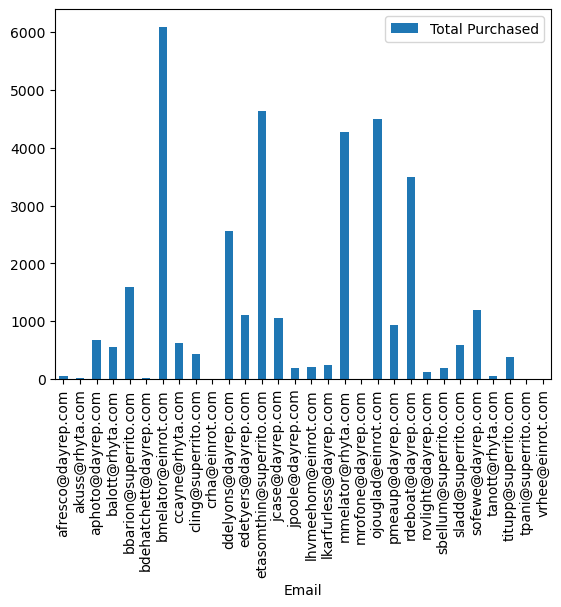

In [14]:
c.toPandas().plot.bar(x="Email", y="Total Purchased")

## IPywidgets

- IPy Widgets allows us to create interactive notebooks
- https://ipywidgets.readthedocs.io/en/latest/
- This is a great example of going from "Big Data" to "Small Data"
- As a rule, we don't want to produce small data (Pandas DataFrame) until we have mapped or reduced results.

In [15]:
from IPython.display import display, HTML
from ipywidgets import interact, interact_manual
c = spark.read.csv("file:///home/jovyan/datasets/customers/customers.csv", inferSchema=True, header=True)

display(HTML("<h1>Customers By State</h1>"))
states = c.select("State").distinct().toPandas()["State"].values
states.sort()
@interact(state=states)
def main(state :str):
    rows = c.where( c.State == state).toPandas()
    display(rows)

interactive(children=(Dropdown(description='state', options=('AZ', 'CA', 'CT', 'FL', 'IL', 'KS', 'MA', 'ME', '…

In [16]:
from IPython.display import display, HTML
from ipywidgets import interact, interact_manual, widgets

display(HTML("<h1>Customers By Total Purchased</h1>"))
rangewidget = widgets.IntRangeSlider(
    value=[10, 1000],
    min=0,
    max=5000,
    step=10,
    description='Total Purchased:',
    disabled=False,
    continuous_update=True,
    orientation='horizontal',
    readout=True,
    readout_format='d',
)

c.createOrReplaceTempView("customers")

@interact_manual(purchased=rangewidget)
def main(purchased: int):
    query = f'select * from customers where `Total Purchased` between {purchased[0]} and {purchased[1]}'
    display(spark.sql(query).toPandas())
    

interactive(children=(IntRangeSlider(value=(10, 1000), description='Total Purchased:', max=5000, step=10), But…

In [17]:
s.printSchema()

root
 |-- Email: string (nullable = true)
 |-- Twitter Username: string (nullable = true)
 |-- Marital Status: string (nullable = true)
 |-- Household Income: string (nullable = true)
 |-- Own Home: string (nullable = true)
 |-- Education: string (nullable = true)
 |-- Favorite Department: string (nullable = true)



In [18]:
s.orderBy("Favorite Department", ascending = False).show()


+--------------------+----------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|               Email|Twitter Username|      Marital Status|    Household Income|            Own Home|           Education| Favorite Department|
+--------------------+----------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|lhvmeehom@einrot.com|       lhvmeehom|Prefer not to Answer|               75000|                 Yes|       4 Year Degree|Prefer not to Answer|
|etasomthin@superr...|      etasomthin|             Married|               39000|                  No|       2 Year Degree|Prefer not to Answer|
| sladd@superrito.com|           sladd|             Married|               52000|                 Yes|       2 Year Degree|                None|
|     akuss@rhyta.com|           akuss|              Single|               22500|                  No|         High School|       

In [12]:
s.orderBy(s["Favorite Department"],ascending = False).show()

+--------------------+----------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|               Email|Twitter Username|      Marital Status|    Household Income|            Own Home|           Education| Favorite Department|
+--------------------+----------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|lhvmeehom@einrot.com|       lhvmeehom|Prefer not to Answer|               75000|                 Yes|       4 Year Degree|Prefer not to Answer|
|etasomthin@superr...|      etasomthin|             Married|               39000|                  No|       2 Year Degree|Prefer not to Answer|
| sladd@superrito.com|           sladd|             Married|               52000|                 Yes|       2 Year Degree|                None|
|     akuss@rhyta.com|           akuss|              Single|               22500|                  No|         High School|       

In [16]:
s.filter( "`Favorite Department` LIKE 'Prefer%' " ).show()


+--------------------+----------------+--------------------+----------------+--------+-------------+--------------------+
|               Email|Twitter Username|      Marital Status|Household Income|Own Home|    Education| Favorite Department|
+--------------------+----------------+--------------------+----------------+--------+-------------+--------------------+
|lhvmeehom@einrot.com|       lhvmeehom|Prefer not to Answer|           75000|     Yes|4 Year Degree|Prefer not to Answer|
|etasomthin@superr...|      etasomthin|             Married|           39000|      No|2 Year Degree|Prefer not to Answer|
+--------------------+----------------+--------------------+----------------+--------+-------------+--------------------+



In [23]:
from pyspark.sql.functions import *
s.filter(col("Favorite Department").startswith("Prefer") ).show()

+--------------------+----------------+--------------------+----------------+--------+-------------+--------------------+
|               Email|Twitter Username|      Marital Status|Household Income|Own Home|    Education| Favorite Department|
+--------------------+----------------+--------------------+----------------+--------+-------------+--------------------+
|lhvmeehom@einrot.com|       lhvmeehom|Prefer not to Answer|           75000|     Yes|4 Year Degree|Prefer not to Answer|
|etasomthin@superr...|      etasomthin|             Married|           39000|      No|2 Year Degree|Prefer not to Answer|
+--------------------+----------------+--------------------+----------------+--------+-------------+--------------------+



In [24]:
s.createOrReplaceTempView("surveys")

In [26]:
spark.sql("show tables").show()

+--------+---------+-----------+
|database|tableName|isTemporary|
+--------+---------+-----------+
|        |  surveys|       true|
+--------+---------+-----------+



In [27]:
z =spark.sql("select * from surveys where `Favorite Department` like 'Prefer%'")

+--------------------+----------------+--------------------+----------------+--------+-------------+--------------------+
|               Email|Twitter Username|      Marital Status|Household Income|Own Home|    Education| Favorite Department|
+--------------------+----------------+--------------------+----------------+--------+-------------+--------------------+
|lhvmeehom@einrot.com|       lhvmeehom|Prefer not to Answer|           75000|     Yes|4 Year Degree|Prefer not to Answer|
|etasomthin@superr...|      etasomthin|             Married|           39000|      No|2 Year Degree|Prefer not to Answer|
+--------------------+----------------+--------------------+----------------+--------+-------------+--------------------+



In [28]:
y = s.filter(col("Favorite Department").startswith("Prefer") )
z =spark.sql("select * from surveys where `Favorite Department` like 'Prefer%'")

In [29]:
y.explain()

== Physical Plan ==
*(1) Filter (isnotnull(Favorite Department#99) AND StartsWith(Favorite Department#99, Prefer))
+- FileScan csv [Email#93,Twitter Username#94,Marital Status#95,Household Income#96,Own Home#97,Education#98,Favorite Department#99] Batched: false, DataFilters: [isnotnull(Favorite Department#99), StartsWith(Favorite Department#99, Prefer)], Format: CSV, Location: InMemoryFileIndex[file:/home/jovyan/datasets/customers/surveys.csv], PartitionFilters: [], PushedFilters: [IsNotNull(Favorite Department), StringStartsWith(Favorite Department,Prefer)], ReadSchema: struct<Email:string,Twitter Username:string,Marital Status:string,Household Income:string,Own Hom...




In [30]:
z.explain()

== Physical Plan ==
*(1) Filter (isnotnull(Favorite Department#99) AND StartsWith(Favorite Department#99, Prefer))
+- FileScan csv [Email#93,Twitter Username#94,Marital Status#95,Household Income#96,Own Home#97,Education#98,Favorite Department#99] Batched: false, DataFilters: [isnotnull(Favorite Department#99), StartsWith(Favorite Department#99, Prefer)], Format: CSV, Location: InMemoryFileIndex[file:/home/jovyan/datasets/customers/surveys.csv], PartitionFilters: [], PushedFilters: [IsNotNull(Favorite Department), StringStartsWith(Favorite Department,Prefer)], ReadSchema: struct<Email:string,Twitter Username:string,Marital Status:string,Household Income:string,Own Hom...




In [32]:
query = '''

SELECT *
    FROM  surveys
    WHERE `Favorite Department` like 'Prefer%'

'''

spark.sql(query)

+--------------------+
|               Email|
+--------------------+
|lhvmeehom@einrot.com|
|etasomthin@superr...|
+--------------------+



In [ ]:
#pyspark
spark.read.csv("s3a://....")

In [ ]:
spark.read.format("csv").load("s3a:///...")

In [ ]:
s.write.format("foo.bvar.avro").mode("errorifexists")\
    .option("sep","-").option("header",True).save("file:///foo.csv")

In [38]:
gp.select("geometry.location.lat",gp.geometry.location.lng.alias("lng")  ).show()

+-----------------+------------------+
|              lat|               lng|
+-----------------+------------------+
|       43.0481221|-76.14742439999999|
|       43.0476078|       -76.1417642|
|       43.0476157|        -76.140986|
|       43.0472894|-76.15385049999999|
|       43.0488846|       -76.1561175|
|43.05264399999999|-76.14681999999999|
|       43.0391534|       -76.1351158|
|       43.0464172|-76.13539879999999|
|       43.0526411|-76.15469379999999|
|43.04396249999999|-76.13607999999999|
|43.04123120000001|       -76.1338203|
|       43.0446639|       -76.1481366|
|       43.0457297|       -76.1483396|
|       43.0414634|        -76.138599|
|        43.048302|        -76.155406|
|        43.050228|        -76.154804|
|43.03901020000001|       -76.1389683|
|        43.042709|        -76.140511|
|43.04229789999999|       -76.1395979|
|43.03426049999999|       -76.1242405|
+-----------------+------------------+



In [39]:
gp.select(col("geometry.location.lat").alias("g.l.lat"),gp.geometry.location.lng.alias("g.l.lng")  ).show()

+-----------------+------------------+
|          g.l.lat|           g.l.lng|
+-----------------+------------------+
|       43.0481221|-76.14742439999999|
|       43.0476078|       -76.1417642|
|       43.0476157|        -76.140986|
|       43.0472894|-76.15385049999999|
|       43.0488846|       -76.1561175|
|43.05264399999999|-76.14681999999999|
|       43.0391534|       -76.1351158|
|       43.0464172|-76.13539879999999|
|       43.0526411|-76.15469379999999|
|43.04396249999999|-76.13607999999999|
|43.04123120000001|       -76.1338203|
|       43.0446639|       -76.1481366|
|       43.0457297|       -76.1483396|
|       43.0414634|        -76.138599|
|        43.048302|        -76.155406|
|        43.050228|        -76.154804|
|43.03901020000001|       -76.1389683|
|        43.042709|        -76.140511|
|43.04229789999999|       -76.1395979|
|43.03426049999999|       -76.1242405|
+-----------------+------------------+



In [41]:
gp.select("geometry.location.lat",gp.geometry.location.lng ).toDF("g.l.lat","g.l.lng").show()

+-----------------+------------------+
|          g.l.lat|           g.l.lng|
+-----------------+------------------+
|       43.0481221|-76.14742439999999|
|       43.0476078|       -76.1417642|
|       43.0476157|        -76.140986|
|       43.0472894|-76.15385049999999|
|       43.0488846|       -76.1561175|
|43.05264399999999|-76.14681999999999|
|       43.0391534|       -76.1351158|
|       43.0464172|-76.13539879999999|
|       43.0526411|-76.15469379999999|
|43.04396249999999|-76.13607999999999|
|43.04123120000001|       -76.1338203|
|       43.0446639|       -76.1481366|
|       43.0457297|       -76.1483396|
|       43.0414634|        -76.138599|
|        43.048302|        -76.155406|
|        43.050228|        -76.154804|
|43.03901020000001|       -76.1389683|
|        43.042709|        -76.140511|
|43.04229789999999|       -76.1395979|
|43.03426049999999|       -76.1242405|
+-----------------+------------------+



In [45]:
from pyspark import SparkFiles

In [50]:
spark.sparkContext.addFile("https://raw.githubusercontent.com/mafudge/datasets/master/crime/nys-crime-1960-2012.csv")
df = spark.read.option("inferSchema",True).option("header", True)\
    .csv(SparkFiles.get("nys-crime-1960-2012.csv"))
df.printSchema()

root
 |-- Year: integer (nullable = true)
 |-- Population: double (nullable = true)
 |-- Violent crime total: double (nullable = true)
 |-- Murder and nonnegligent Manslaughter: double (nullable = true)
 |-- Forcible rape: double (nullable = true)
 |-- Robbery: double (nullable = true)
 |-- Aggravated assault: double (nullable = true)
 |-- Property crime total: double (nullable = true)
 |-- Burglary: double (nullable = true)
 |-- Larceny-theft: double (nullable = true)
 |-- Motor vehicle theft: double (nullable = true)
 |-- _c11: string (nullable = true)



In [49]:
SparkFiles.get("nys-crime-1960-2012.csv")

'/tmp/spark-69583df6-d589-41c4-83a9-4de535ffd62c/userFiles-00fd3eba-9da4-466b-b3d8-c534dab26904/nys-crime-1960-2012.csv'

In [6]:
from IPython.display import display, HTML
from ipywidgets import interact, interact_manual


@interact_manual(name="", age=(1,99), retired=False, hobbies=["Biking","Skiing"])
def onclick(name,age,retired,hobbies):
    display(HTML(f"<p>{name}, {age} {retired} {hobbies}"))
    


interactive(children=(Text(value='', description='name'), IntSlider(value=50, description='age', max=99, min=1…